# Autoencoder to Build a Flying Fish



By Yaohang

In [1]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import Activation
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


## Load the data

In [2]:
fish = np.load('fish.npy')
airplane = np.load('airplane.npy')
data = np.concatenate((fish[:2000, :], airplane[:2000,:]))

## Add label to the data

In [3]:
# add a column with labels, 0=flamingo, 1=fish
data = np.c_[data, data]

print(data.shape)

(4000, 1568)


## Visualize the fishes and airplanes

In [4]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

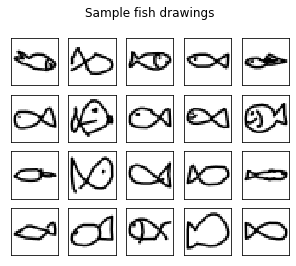

In [5]:
plot_samples(fish, title='Sample fish drawings\n')

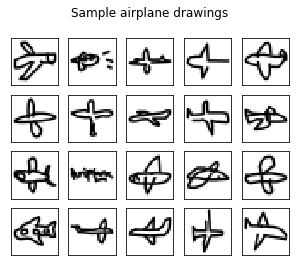

In [6]:
plot_samples(airplane, title="Sample airplane drawings\n")

## Split the training set and test set

In [7]:
from sklearn.model_selection import train_test_split

# merge the flamingo and fish arrays, and split the features (X) and labels (y). Convert to float32 to save some memory.
X = data[:4000,:784].astype('float32') # all columns but the last
y = data[:4000,784:].astype('float32') # the last column

# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# I will use a 50:50 split, since I want to start by training the models on 5'000 samples and thus have plenty of samples to spare for testing.
X_train, X_test, y_train, y_test = train_test_split(X/255.,y/255.,test_size=0.2,random_state=0)
# X_test = np.append(X_test, bear[0, :784].reshape(1, 784)/255., axis = 0)
# y_test = np.append(y_test, bear[0, 784:].reshape(1, 784)/255., axis = 0)

In [8]:
X_test.shape

(800, 784)

In [9]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
y_train = y_train.reshape(y_train.shape[0], 28, 28, 1).astype('float32')
y_test = y_test.reshape(y_test.shape[0], 28, 28, 1).astype('float32')

## Setup the autoencoder parameters
The autoencoder condenses the 28x28 image into an 8-dimensional latent vector.

In [10]:
# Network parameters
input_shape = (28, 28, 1)
batch_size = 128
kernel_size = 3

# size of latent vector
latent_dim = 32
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

## Build the autoencoder

In [11]:
# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                1605664   
Total params: 1,624,480
Trainable params: 1,624,480
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=1,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50176)             1655808   
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0         
Total para

In [13]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 32)                1624480   
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         1711489   
Total params: 3,335,969
Trainable params: 3,335,969
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.compile(optimizer = 'adam',
                   loss = 'mse')

## Train the autoencoder

In [15]:
# Fit the model
autoencoder.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100)
# Final evaluation of the model

Instructions for updating:
Use tf.cast instead.
Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 29s 9ms/step - loss: 0.1070 - val_loss: 0.0796
Epoch 2/10
3200/3200 [==============================] - 22s 7ms/step - loss: 0.0777 - val_loss: 0.0760
Epoch 3/10
3200/3200 [==============================] - 20s 6ms/step - loss: 0.0741 - val_loss: 0.0725
Epoch 4/10
3200/3200 [==============================] - 20s 6ms/step - loss: 0.0708 - val_loss: 0.0695
Epoch 5/10
3200/3200 [==============================] - 20s 6ms/step - loss: 0.0675 - val_loss: 0.0657
Epoch 6/10
3200/3200 [==============================] - 20s 6ms/step - loss: 0.0623 - val_loss: 0.0584
Epoch 7/10
3200/3200 [==============================] - 20s 6ms/step - loss: 0.0539 - val_loss: 0.0505
Epoch 8/10
3200/3200 [==============================] - 21s 6ms/step - loss: 0.0449 - val_loss: 0.0406
Epoch 9/10
3200/3200 [==============================] - 20s 6ms/step - loss: 0.03

## Run the autoencoder on the test set

In [16]:
fish_test = fish[5000:5100, :]
airplane_test = airplane[5000:5100, :]
fish_test = fish_test.reshape(fish_test.shape[0], 28, 28, 1).astype('float32')
airplane_test = airplane_test.reshape(airplane_test.shape[0], 28, 28, 1).astype('float32')

In [17]:
fish_predict = autoencoder.predict(fish_test)
airplane_predict = autoencoder.predict(airplane_test)

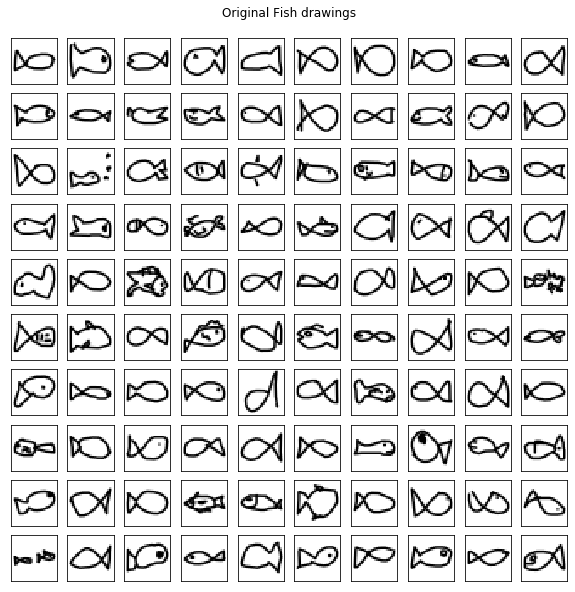

In [18]:
plot_samples(fish_test, rows = 10, cols = 10, title='Original Fish drawings\n')

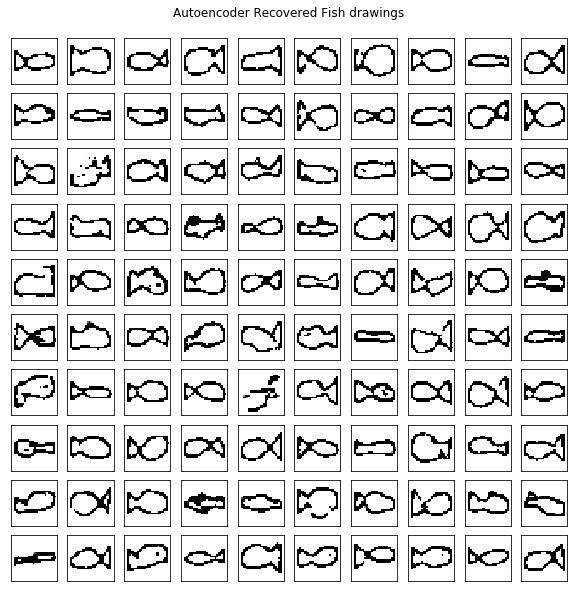

In [19]:
plot_samples(fish_predict, rows = 10, cols = 10, title='Autoencoder Recovered Fish drawings\n')

# Here is an airplane

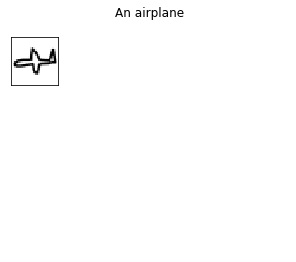

In [20]:
plot_samples(airplane_test[8].reshape(1, 28, 28), title='An airplane\n')

## Get the airplane vector

In [21]:
airplanevec = encoder.predict(airplane_test[8].reshape(1, 28, 28, 1))

## Add the airplane vector to the fish vector
# Now we have the Flying Fish!

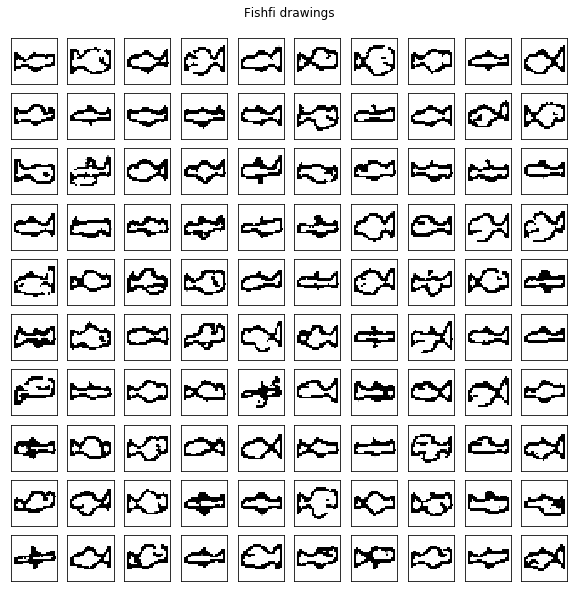

In [23]:
# fishairplane = decoder.predict((encoder.predict(fish_test)*0.5 + encoder.predict(airplane_test[8])*0.5))
fishairplane = decoder.predict((encoder.predict(fish_test)*0.6 + airplanevec*0.4))
plot_samples(fishairplane, rows = 10, cols = 10, title='Fishfi drawings\n')